In [15]:
import pandas as pd
import numpy as np
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModel.from_pretrained('roberta-base')

import warnings
warnings.filterwarnings('ignore')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://huggingface.co/datasets/FIG-Loneliness/FIG-Loneliness

In [16]:
dataset = Dataset.from_file("data/train_set_dataset.arrow")
dataframe = dataset.to_pandas()
dataframe.head()

,context_pri,idx,interaction,interpersonal_pri,lonely,temporal,text,unique_id
0,"[0, 0, 0, 0, 0]",5359,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0]","[0, 0, 0, 0]",Should I transfer? Other than the fact that th...,85tbvc
1,"[0, 0, 0, 0, 0]",3985,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0]","[0, 0, 0, 0]",Summer Financial Aid Does anyone have any reco...,exptn4
2,"[0, 0, 0, 3, 0]",2248,"[2, 0, 0, 0, 1]","[3, 0, 0, 0, 0]","[0, 1]","[0, 0, 2, 1]",How do you forget a girl? If you saw my last p...,a3619d
3,"[0, 0, 0, 0, 0]",2765,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0]","[0, 0, 0, 0]",Financing College Hi guys. With my parents sho...,acmme5
4,"[0, 0, 0, 0, 0]",3047,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0]","[0, 0, 0, 0]",Dealing with taking a gap year you didn't inte...,hfiq0h


In [17]:
df = dataframe[['text', 'interaction']]
df.tail(10)

# Interaction. 5-len vector summarizing human annotators' votings in the order of 
# [seeking advice, providing help, seeking validation and affirmation, reaching out, non directed interaction]

,text,interaction
3933,Should I stay or should I go I have a best fri...,"[3, 0, 0, 0, 0]"
3934,(f) hello! does anyone wanna chat? you can ven...,"[0, 3, 0, 0, 0]"
3935,My first New Year celebration when I will be c...,"[2, 0, 1, 0, 0]"
3936,Is a 22/18 predatory in general This is someth...,"[0, 0, 0, 0, 0]"
3937,College Decision I got waitlisted at UW Madiso...,"[0, 0, 0, 0, 0]"
3938,Freshman at Villanova Struggling to make frien...,"[0, 0, 0, 0, 3]"
3939,"When applying to college, is there a big diffe...","[0, 0, 0, 0, 0]"
3940,I just want someone to be around Have hardly s...,"[0, 0, 0, 0, 3]"
3941,Professor has not been responding to emails......,"[0, 0, 0, 0, 0]"
3942,"Somewhere out there... Somewhere out there, th...","[0, 0, 0, 1, 2]"


In [18]:
# df['interaction'] = df['interaction'].apply(eval)

extending_columns = ['seeking_advice', 'providing_help', 'seeking_validation', 'reaching_out', 'non_directed_interaction']

# Split the interaction column into 5 separate columns
df[extending_columns] = pd.DataFrame(df['interaction'].tolist(), index=df.index)


df = df.drop('interaction', axis=1)
df.tail()

,text,seeking_advice,providing_help,seeking_validation,reaching_out,non_directed_interaction
3938,Freshman at Villanova Struggling to make frien...,0,0,0,0,3
3939,"When applying to college, is there a big diffe...",0,0,0,0,0
3940,I just want someone to be around Have hardly s...,0,0,0,0,3
3941,Professor has not been responding to emails......,0,0,0,0,0
3942,"Somewhere out there... Somewhere out there, th...",0,0,0,1,2


In [19]:
df['category'] =np.where(df[extending_columns].nunique(axis=1) == 1, 
                  'other', 
                  df[extending_columns].idxmax(axis=1))

df.drop(columns=extending_columns, inplace=True)

In [20]:
df['category'].value_counts()

category
other                       2103
non_directed_interaction    1243
reaching_out                 210
seeking_advice               200
seeking_validation           112
providing_help                75
Name: count, dtype: int64

## We'll have to downsample both other and non_directed_interaction

In [21]:
trimmed = []
for category in df['category'].unique():
    selected_df = df[df['category'] == category].sample(n=100, replace=True)
    trimmed.append(selected_df)

trimmed_df = pd.concat(trimmed)
trimmed_df = trimmed_df.sample(len(trimmed_df)) # Shuffle dataset
trimmed_df['category'].value_counts()


category
providing_help              100
seeking_validation          100
reaching_out                100
non_directed_interaction    100
seeking_advice              100
other                       100
Name: count, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(trimmed_df['text'], trimmed_df['category'], test_size=0.2, random_state=42, stratify=trimmed_df['category'])

X_train.head()

337     Getting tired of being alone and lonely but ha...
2849    Is talking to an AI Chatbot healthy? I've rece...
2554    Gods I just want some friends. Everyday is the...
3093    Anyone feeling lonely out there?? I’ll be your...
2736    Loving yourself My now ex girlfriend told me I...
Name: text, dtype: object

In [23]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [24]:
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(2, 3)),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.58


# Bert embeddings

In [25]:
# Function to get BERT embeddings
def get_bert_embeddings(texts, max_length=512):
    # Tokenize texts
    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(**encoded)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    return embeddings

In [26]:
X_train_embeddings = get_bert_embeddings(X_train.tolist())
X_test_embeddings = get_bert_embeddings(X_test.tolist())

embeddings_pipeline = make_pipeline(
    RandomForestClassifier(n_estimators=100, random_state=42)
)

embeddings_pipeline.fit(X_train_embeddings, y_train)

predictions = embeddings_pipeline.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [27]:
from sklearn.linear_model import LogisticRegression

embeddings_pipeline_2 = make_pipeline(
    LogisticRegression(max_iter=1000)
)

embeddings_pipeline_2.fit(X_train_embeddings, y_train)

predictions = embeddings_pipeline_2.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


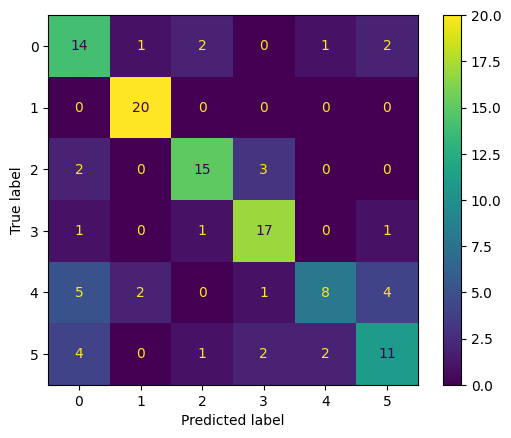

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix_ = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix_).plot()